# Preface

Objectives:
1. Learn to use the `keras` API
2. Explore how performance of fully connected neural networks depend on its hyper-parameters
3. Explore the effect of learning rate and batch size on training and testing performance

Due: 4 Feb 2023

In [ ]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set(font_scale=1.5)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Feb  2 14:28:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    33W /  70W |   1502MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6085041773513671799
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14417788928
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1411550414137549897
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

# The Fashion MNIST Dataset

As mentioned in class the saying,
> *If you model works for MNIST, it may not work for anything else, but if it doesn't work for MNIST, it won't work for anything else*

Here in this notebook you will go beyond the MNIST dataset, albeit only a little bit. We will use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset, which is designed to replace MNIST as the new minimal dataset to test vision tasks. 

It is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Thus, it is almost exactly like the MNIST dataset for digit recognition, but the classification problem is generally harder.


Here are some example images:
![Fashion MNIST](https://markusthill.github.io/images/2017-10-12-zalandos-fashion-mnist-dataset/zalando10x10.jpeg)

# Importing the Dataset

Just like MNIST, this dataset is found in the `tf.keras.datasets` module.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# change the data types for model training process

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

The following is a dictionary of labels that will map the y_train/y_test labels into words

In [ ]:
# for illustration purpose
label_dict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot',
}
labels_train = [label_dict[u] for u in y_train]
labels_test = [label_dict[u] for u in y_test]

Text(0.5, 1.0, 'Label = Ankle boot')

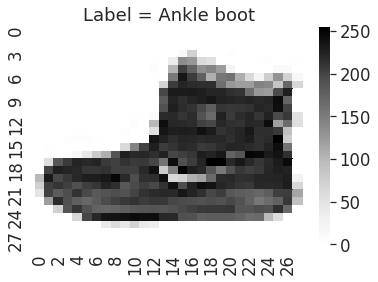

In [ ]:
ax = sns.heatmap(x_train[0], cmap='Greys')
ax.set_title(f'Label = {labels_train[0]}')

# Task 1: Build a Shallow NN for Classification

Build and train a shallow (one-hidden-layer) neural network with 128 hidden nodes to classify these images. Remember to perform appropriate preprocessing steps, such as normalization and one-hot representations.

Evaluate carefully the performance of your training and the final model's performance. Discuss any interesting phenomena you discover.

## Data Pre-processing

In [ ]:
# 1. One-hot encoding; 
# 2. Normalization for the input pixel;

# one-hot encoding for labels
y_train_onehot = pd.get_dummies(pd.DataFrame(labels_train), prefix='label')
y_test_onehot = pd.get_dummies(pd.DataFrame(labels_test), prefix='label')
y_train_onehot = y_train_onehot.values.astype('float32')
y_test_onehot = y_test_onehot.values.astype('float32')

# Normalization for inputs (min-max normalization)
x_train_normal = x_train / 255
x_test_normal = x_test / 255

In [ ]:
# Illustration [a) data types change; b) one-hot encoding]
## labels shape
y_train_onehot.shape, y_test_onehot.shape

((60000, 10), (10000, 10))

In [ ]:
## labels element
y_train_onehot[0,:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
# inputs element [before and after normalization]
x_train[0][5]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   6.,   0., 102., 204., 176., 134., 144., 123.,  23.,   0.,
         0.,   0.,   0.,  12.,  10.,   0.], dtype=float32)

In [ ]:
x_train_normal[0][5]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02352941, 0.        , 0.4       ,
       0.8       , 0.6901961 , 0.5254902 , 0.5647059 , 0.48235294,
       0.09019608, 0.        , 0.        , 0.        , 0.        ,
       0.04705882, 0.03921569, 0.        ], dtype=float32)

## **28*28-128-10** MLP Baseline (Shallow NN)

### 1. Model Building (Baseline)
- one-hot encoding for the label (Data pre-processing)
- add first **flatten** layer in order to flatten the 2D-pixel to 1D-data
### Model Setting (**28×28-128-10** MLP Architecture):
1. activation function: ReLu
2. hidden units: 128
3. Loss Function: Cross-Entropy Loss
4. Optimizer: Adam
5. Performance metric: Top-1 Accuracy, Top-2 Accuracy
### Remarks (after finishing the baseline model):
- As for **Performance Metric**, it is more fair to compare **top-2 accuracy**. That is because, some classification task might be invariant under rotation. It is not reasonable that only checking the top-1 accuracy in the manner.
- Acutally here output one-hot encoding part is **not necessary** since 'keras' support **'SparseCategoricalCrossentropy' loss function** which can take the ordinal output
- Be careful that, if we do not use one-hot encoding outputs, then we should also apply metrices like **'SparseCategoricalAccuracy'** for model evaluation

In [ ]:
import numpy as np

# create the baseline model
mlp_baseline = tf.keras.models.Sequential()
mlp_baseline.add(tf.keras.layers.Flatten(input_shape = (28, 28)))
mlp_baseline.add(tf.keras.layers.Dense(128, activation = 'relu'))
mlp_baseline.add(tf.keras.layers.Dense(10, activation = 'softmax'))

mlp_baseline.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 784)               0         
                                                                 
 dense_18 (Dense)            (None, 128)               100480    
                                                                 
 dense_19 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# modify the learning parameter (loss function, optimization method and performance metric)
mlp_baseline.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2)]
)

### 2. Model Training and Performance Evaluation

In [ ]:
# model training
history = mlp_baseline.fit(x_train_normal, y_train, validation_data = (x_test_normal, y_test), batch_size=32, epochs=100, verbose=0)

# model evaluation
_, train_acc, _ = mlp_baseline.evaluate(x_train_normal, y_train)
_, test_acc, _ = mlp_baseline.evaluate(x_test_normal, y_test)

print('Accuracy Report:')
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


313/313 [==============================] - 1s 3ms/step - loss: 0.8067 - sparse_categorical_accuracy: 0.8856 - sparse_top_k_categorical_accuracy: 0.9659
Accuracy Report:
Train: 0.972, Test: 0.886


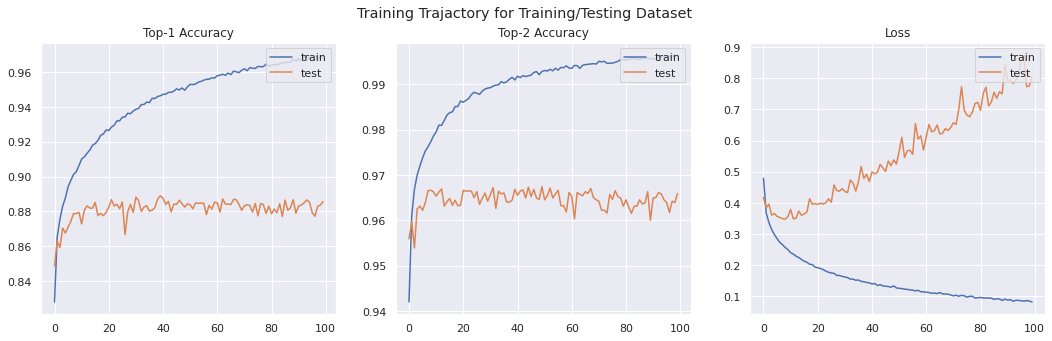

In [ ]:
# visualization for [top1 accuracy, top2 accurcay, loss] comparison
sns.set(font_scale=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(18, 5)
fig.suptitle('Training Trajactory for Training/Testing Dataset \n')


# top-1 accuracy
ax1.set_title('Top-1 Accuracy')
ax1.plot(history.history['sparse_categorical_accuracy'], label='train')
ax1.plot(history.history['val_sparse_categorical_accuracy'], label='test')
ax1.legend(loc = 'upper right')

# top-2 accuracy
ax2.set_title('Top-2 Accuracy')
ax2.plot(history.history['sparse_top_k_categorical_accuracy'], label='train')
ax2.plot(history.history['val_sparse_top_k_categorical_accuracy'], label='test')
ax2.legend(loc = 'upper right')

# loss
ax3.set_title('Loss')
ax3.plot(history.history['loss'], label='train')
ax3.plot(history.history['val_loss'], label='test')
ax3.legend(loc = 'upper right')

plt.show()

### 3. Findings:
- Given that we use the most trivial MLP model (do not apply any tricks like **Batch Normalization** or **Dropout** etc.), the model is prone to over-fitting;
  - Through the **Model Evaluation (visualization)** part, it can be observed that, through the training process, training loss keeps decreasing while validation (testing) loss decreases in the early stage and saturates in the late stage;
  - Same situation holds for the training accuracy and validation (testing) accuracy;
- Actually 28×28-128-1 MLP can fit the training data very well, which can be of the evidence that **MLP is universal approxiamtor**. However, we cannot guarantee its generalization performance.
- It is highly likely that, this model is **over-fitting** without tricks like **'early stop'**.

# Task 2: Dependence on Hyper-parameters

Now, investigate the dependence of the neural network's performance on some hyper-parameters. In particular, you should investigate the dependence on the following:

1. Number of hidden nodes
2. The activation function
3. Loss functions

Discuss any interesting findings and insights.

## 1. Fix other Hyper-parameters (w.r.t baseline model), changing the number of hidden nodes (512 hidden units and 32 hidden units)

### a) 512 hidden units

In [ ]:
mlp_11 = tf.keras.models.Sequential()
mlp_11.add(tf.keras.layers.Flatten(input_shape = (28, 28)))
mlp_11.add(tf.keras.layers.Dense(512, activation = 'relu'))
mlp_11.add(tf.keras.layers.Dense(10, activation = 'softmax'))

mlp_11.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2)],
)

history = mlp_11.fit(x_train_normal, y_train, validation_data = (x_test_normal, y_test), batch_size=32, epochs=100, verbose=0)

# model evaluation
_, train_acc, _ = mlp_11.evaluate(x_train_normal, y_train)
_, test_acc, _ = mlp_11.evaluate(x_test_normal, y_test)

print('Accuracy Report:')
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

313/313 [==============================] - 1s 3ms/step - loss: 0.9443 - sparse_categorical_accuracy: 0.8801 - sparse_top_k_categorical_accuracy: 0.9624
Accuracy Report:
Train: 0.968, Test: 0.880


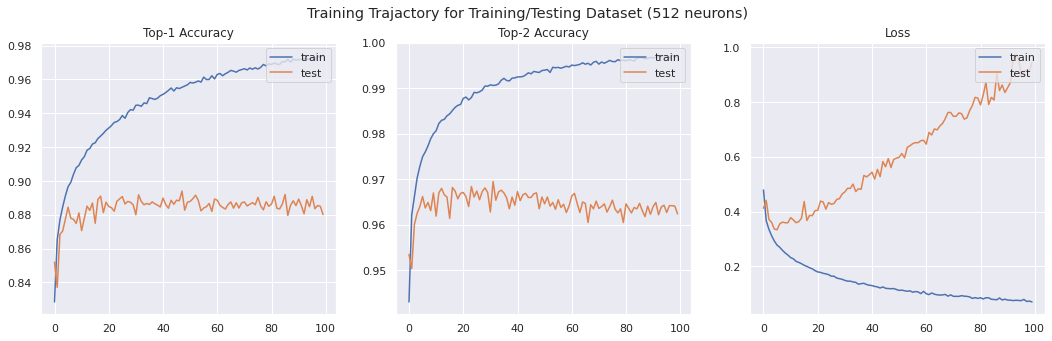

In [ ]:
# visualization for [top1 accuracy, top2 accurcay, loss] comparison
sns.set(font_scale=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(18, 5)
fig.suptitle('Training Trajactory for Training/Testing Dataset (512 neurons)')

# top-1 accuracy
ax1.set_title('Top-1 Accuracy')
ax1.plot(history.history['sparse_categorical_accuracy'], label='train')
ax1.plot(history.history['val_sparse_categorical_accuracy'], label='test')
ax1.legend(loc = 'upper right')

# top-2 accuracy
ax2.set_title('Top-2 Accuracy')
ax2.plot(history.history['sparse_top_k_categorical_accuracy'], label='train')
ax2.plot(history.history['val_sparse_top_k_categorical_accuracy'], label='test')
ax2.legend(loc = 'upper right')

# loss
ax3.set_title('Loss')
ax3.plot(history.history['loss'], label='train')
ax3.plot(history.history['val_loss'], label='test')
ax3.legend(loc = 'upper right')

plt.show()

### b) 32 hidden units

In [ ]:
mlp_12 = tf.keras.models.Sequential()
mlp_12.add(tf.keras.layers.Flatten(input_shape = (28, 28)))
mlp_12.add(tf.keras.layers.Dense(32, activation = 'relu'))
mlp_12.add(tf.keras.layers.Dense(10, activation = 'softmax'))

mlp_12.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2)],
)

history = mlp_12.fit(x_train_normal, y_train, validation_data = (x_test_normal, y_test), batch_size=32, epochs=100, verbose=0)

# model evaluation
_, train_acc, _ = mlp_12.evaluate(x_train_normal, y_train)
_, test_acc, _ = mlp_12.evaluate(x_test_normal, y_test)

print('Accuracy Report:')
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.5662 - sparse_categorical_accuracy: 0.8671 - sparse_top_k_categorical_accuracy: 0.9536
Accuracy Report:
Train: 0.935, Test: 0.867


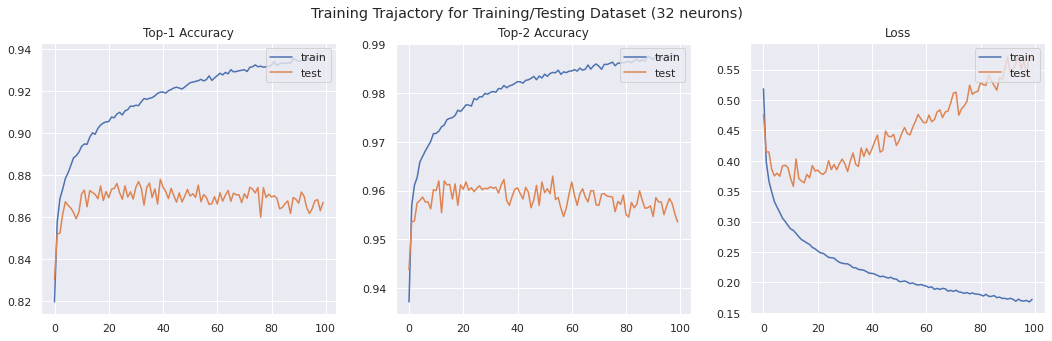

In [ ]:
# visualization for [top1 accuracy, top2 accurcay, loss] comparison
sns.set(font_scale=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(18, 5)
fig.suptitle('Training Trajactory for Training/Testing Dataset (32 neurons)')

# top-1 accuracy
ax1.set_title('Top-1 Accuracy')
ax1.plot(history.history['sparse_categorical_accuracy'], label='train')
ax1.plot(history.history['val_sparse_categorical_accuracy'], label='test')
ax1.legend(loc = 'upper right')

# top-2 accuracy
ax2.set_title('Top-2 Accuracy')
ax2.plot(history.history['sparse_top_k_categorical_accuracy'], label='train')
ax2.plot(history.history['val_sparse_top_k_categorical_accuracy'], label='test')
ax2.legend(loc = 'upper right')

# loss
ax3.set_title('Loss')
ax3.plot(history.history['loss'], label='train')
ax3.plot(history.history['val_loss'], label='test')
ax3.legend(loc = 'upper right')

plt.show()

### Findings:
- comparison between 32, 128, 512 hidden neurons:
  - Loss function perspective
    - 1. Theoretically, more hidden neurons means more model capacity. That is, if models can be trained enough (sufficiently large epoches number), then NN with 512 hidden neurons will have the smallest loss function value;
    - 2. However, actually NN with 128 hidden neurons achieve the smallest loss function value with 100 epoches. Reasons can be, the trade-off between model capacity and training difficulty. With larger number of hidden neurons, the NN is more difficult to train, which means it will require more epoches to converge. This is why NN with 512 neurons have larger loss function value than that with 128 neurons since its parameters (weights) haven't been tuned enough yet.
  - Over-fitting perspective
    - 1. For all choices of hidden neuron number, we all suffer from over-fitting issue.
    - 2. Generalization ability for 3 NNs are quite similar, with around 0.88 testing top-1 accuracy.

## 2. Fix other Hyper-parameters, changing the activation function (tanh and sigmoid)


### a) tanh()

In [ ]:
mlp_21 = tf.keras.models.Sequential()
mlp_21.add(tf.keras.layers.Flatten(input_shape = (28, 28)))
mlp_21.add(tf.keras.layers.Dense(128, activation = 'tanh'))
mlp_21.add(tf.keras.layers.Dense(10, activation = 'softmax'))

mlp_21.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2)],
)

history = mlp_21.fit(x_train_normal, y_train, validation_data = (x_test_normal, y_test), batch_size=32, epochs=100, verbose=0)

# model evaluation
_, train_acc, _ = mlp_21.evaluate(x_train_normal, y_train)
_, test_acc, _ = mlp_21.evaluate(x_test_normal, y_test)

print('Accuracy Report:')
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.4849 - sparse_categorical_accuracy: 0.8751 - sparse_top_k_categorical_accuracy: 0.9577
Accuracy Report:
Train: 0.950, Test: 0.875


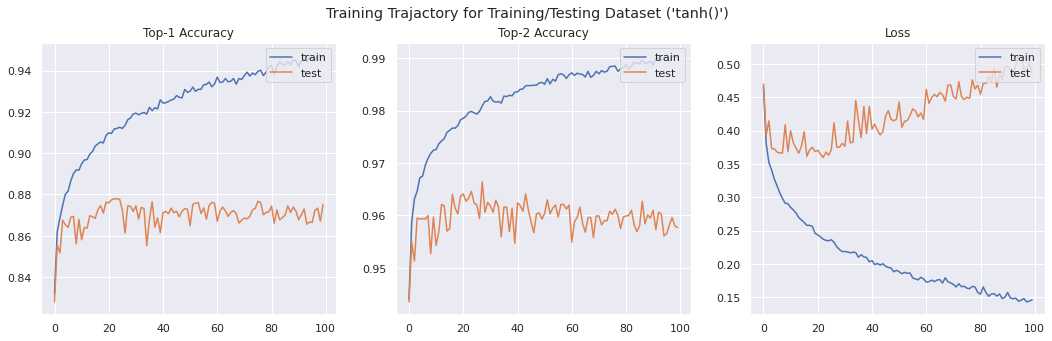

In [ ]:
# visualization for [top1 accuracy, top2 accurcay, loss] comparison
sns.set(font_scale=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(18, 5)
fig.suptitle('Training Trajactory for Training/Testing Dataset (\'tanh()\')')

# top-1 accuracy
ax1.set_title('Top-1 Accuracy')
ax1.plot(history.history['sparse_categorical_accuracy'], label='train')
ax1.plot(history.history['val_sparse_categorical_accuracy'], label='test')
ax1.legend(loc = 'upper right')

# top-2 accuracy
ax2.set_title('Top-2 Accuracy')
ax2.plot(history.history['sparse_top_k_categorical_accuracy'], label='train')
ax2.plot(history.history['val_sparse_top_k_categorical_accuracy'], label='test')
ax2.legend(loc = 'upper right')

# loss
ax3.set_title('Loss')
ax3.plot(history.history['loss'], label='train')
ax3.plot(history.history['val_loss'], label='test')
ax3.legend(loc = 'upper right')

plt.show()

### b) sigmoid()

In [ ]:
mlp_22 = tf.keras.models.Sequential()
mlp_22.add(tf.keras.layers.Flatten(input_shape = (28, 28)))
mlp_22.add(tf.keras.layers.Dense(128, activation = 'sigmoid'))
mlp_22.add(tf.keras.layers.Dense(10, activation = 'softmax'))

mlp_22.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2)],
)

history = mlp_22.fit(x_train_normal, y_train, validation_data = (x_test_normal, y_test), batch_size=32, epochs=100, verbose=0)

# model evaluation
_, train_acc, _ = mlp_22.evaluate(x_train_normal, y_train)
_, test_acc, _ = mlp_22.evaluate(x_test_normal, y_test)

print('Accuracy Report:')
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.6103 - sparse_categorical_accuracy: 0.8825 - sparse_top_k_categorical_accuracy: 0.9623
Accuracy Report:
Train: 0.986, Test: 0.882


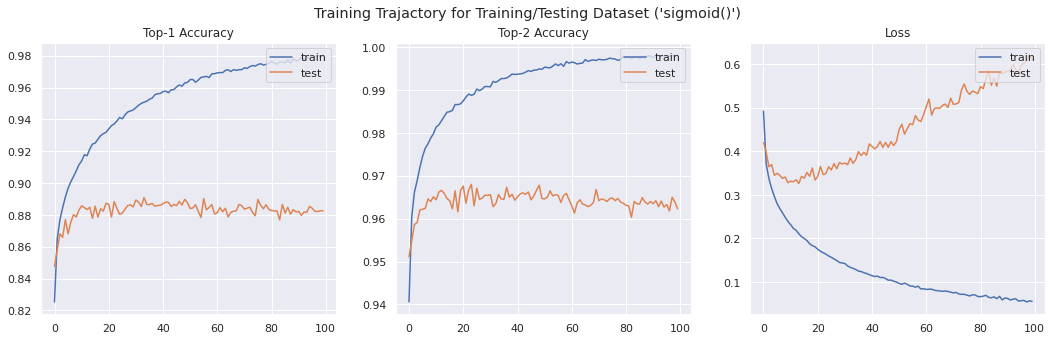

In [ ]:
# visualization for [top1 accuracy, top2 accurcay, loss] comparison
sns.set(font_scale=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(18, 5)
fig.suptitle('Training Trajactory for Training/Testing Dataset (\'sigmoid()\')')

# top-1 accuracy
ax1.set_title('Top-1 Accuracy')
ax1.plot(history.history['sparse_categorical_accuracy'], label='train')
ax1.plot(history.history['val_sparse_categorical_accuracy'], label='test')
ax1.legend(loc = 'upper right')

# top-2 accuracy
ax2.set_title('Top-2 Accuracy')
ax2.plot(history.history['sparse_top_k_categorical_accuracy'], label='train')
ax2.plot(history.history['val_sparse_top_k_categorical_accuracy'], label='test')
ax2.legend(loc = 'upper right')

# loss
ax3.set_title('Loss')
ax3.plot(history.history['loss'], label='train')
ax3.plot(history.history['val_loss'], label='test')
ax3.legend(loc = 'upper right')

plt.show()

### Findings:
- Actually 'sigmoid' activation function behaves quite similar to 'ReLu' activation function; while 'tanh' activation function behaves slightly poorer than those 2 functions.
- Therefore, we may prefer more 'Relu' and 'Sigmoid' activation function.
  - However, it seems that, when using 'ReLu' activation function after training for large epoches, the loss function value on testing data will turn to increase dramatically. 
  - When using 'sigmoid' activation function, the increase of loss function value is not so significant.

## 3. Fix other Hyper-parameters, changing the loss function (KL-divergence Loss and Poisson Loss)
- in both cases, we should use one-hot encoding outputs, which is **different** from **'SparseCategoricalCrossentropy' Loss**

In [ ]:
y_train_onehot.shape, y_test_onehot.shape

((60000, 10), (10000, 10))

In [ ]:
type(y_train_onehot[0][0])

numpy.float32

### a) KL-divergence Loss

In [ ]:
mlp_31 = tf.keras.models.Sequential()
mlp_31.add(tf.keras.layers.Flatten(input_shape = (28, 28)))
mlp_31.add(tf.keras.layers.Dense(128, activation = 'relu'))
mlp_31.add(tf.keras.layers.Dense(10, activation = 'softmax'))

mlp_31.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    loss=tf.keras.losses.KLDivergence(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=2)],
)

history = mlp_31.fit(x_train_normal, y_train_onehot, validation_data = (x_test_normal, y_test_onehot), batch_size=32, epochs=100, verbose=0)

# model evaluation
_, train_acc, train_top2_acc = mlp_31.evaluate(x_train_normal, y_train_onehot)
_, test_acc, test_top2_acc = mlp_31.evaluate(x_test_normal, y_test_onehot)

print('Accuracy Report:')
print('Top1-Accuracy-Train: %.3f, Top1-Accuracy-Test: %.3f' % (train_acc, test_acc))
print('Top2-Accuracy-Train: %.3f, Top1-Accuracy-Test: %.3f' % (train_top2_acc, test_top2_acc))


313/313 [==============================] - 1s 3ms/step - loss: 0.6863 - categorical_accuracy: 0.8749 - top_k_categorical_accuracy: 0.9593
Accuracy Report:
Top1-Accuracy-Train: 0.965, Top1-Accuracy-Test: 0.875
Top2-Accuracy-Train: 0.995, Top1-Accuracy-Test: 0.959


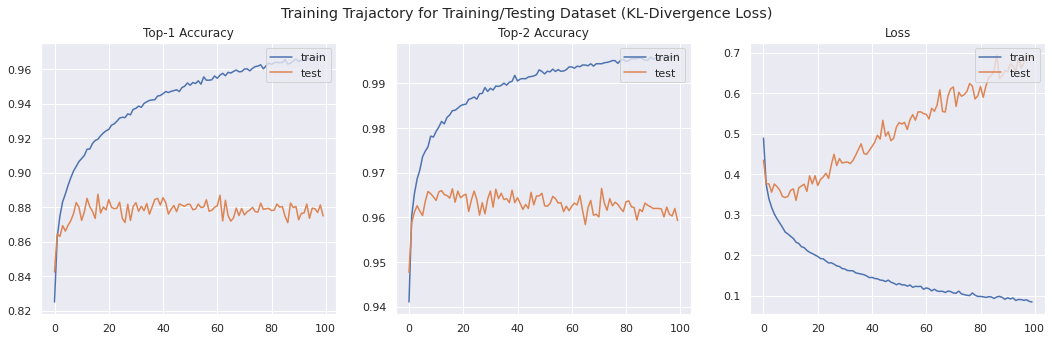

In [ ]:
# visualization for [top1 accuracy, top2 accurcay, loss] comparison
sns.set(font_scale=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(18, 5)
fig.suptitle('Training Trajactory for Training/Testing Dataset (KL-Divergence Loss)')

# top-1 accuracy
ax1.set_title('Top-1 Accuracy')
ax1.plot(history.history['categorical_accuracy'], label='train')
ax1.plot(history.history['val_categorical_accuracy'], label='test')
ax1.legend(loc = 'upper right')

# top-2 accuracy
ax2.set_title('Top-2 Accuracy')
ax2.plot(history.history['top_k_categorical_accuracy'], label='train')
ax2.plot(history.history['val_top_k_categorical_accuracy'], label='test')
ax2.legend(loc = 'upper right')

# loss
ax3.set_title('Loss')
ax3.plot(history.history['loss'], label='train')
ax3.plot(history.history['val_loss'], label='test')
ax3.legend(loc = 'upper right')

plt.show()

### b) Poisson Loss

In [ ]:
mlp_32 = tf.keras.models.Sequential()
mlp_32.add(tf.keras.layers.Flatten(input_shape = (28, 28)))
mlp_32.add(tf.keras.layers.Dense(128, activation = 'relu'))
mlp_32.add(tf.keras.layers.Dense(10, activation = 'softmax'))

mlp_32.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    loss=tf.keras.losses.Poisson(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=2)],
)

history = mlp_32.fit(x_train_normal, y_train_onehot, validation_data = (x_test_normal, y_test_onehot), batch_size=32, epochs=100, verbose=0)

# model evaluation
_, train_acc, train_top2_acc = mlp_32.evaluate(x_train_normal, y_train_onehot)
_, test_acc, test_top2_acc = mlp_32.evaluate(x_test_normal, y_test_onehot)

print('Accuracy Report:')
print('Top1-Accuracy-Train: %.3f, Top1-Accuracy-Test: %.3f' % (train_acc, test_acc))
print('Top2-Accuracy-Train: %.3f, Top1-Accuracy-Test: %.3f' % (train_top2_acc, test_top2_acc))


313/313 [==============================] - 1s 3ms/step - loss: 0.1691 - categorical_accuracy: 0.8802 - top_k_categorical_accuracy: 0.9600
Accuracy Report:
Top1-Accuracy-Train: 0.970, Top1-Accuracy-Test: 0.880
Top2-Accuracy-Train: 0.996, Top1-Accuracy-Test: 0.960


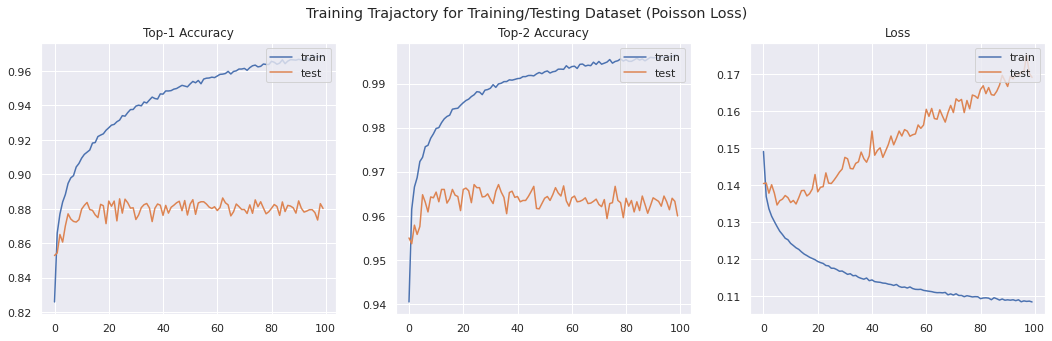

In [ ]:
# visualization for [top1 accuracy, top2 accurcay, loss] comparison
sns.set(font_scale=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(18, 5)
fig.suptitle('Training Trajactory for Training/Testing Dataset (Poisson Loss)')

# top-1 accuracy
ax1.set_title('Top-1 Accuracy')
ax1.plot(history.history['categorical_accuracy'], label='train')
ax1.plot(history.history['val_categorical_accuracy'], label='test')
ax1.legend(loc = 'upper right')

# top-2 accuracy
ax2.set_title('Top-2 Accuracy')
ax2.plot(history.history['top_k_categorical_accuracy'], label='train')
ax2.plot(history.history['val_top_k_categorical_accuracy'], label='test')
ax2.legend(loc = 'upper right')

# loss
ax3.set_title('Loss')
ax3.plot(history.history['loss'], label='train')
ax3.plot(history.history['val_loss'], label='test')
ax3.legend(loc = 'upper right')

plt.show()

### Findings and insights:
- Most basically, we should measure our model performance by metrics like 'accuracy', 'top_k_accuracy' instead of 'losses' since different losses have different range.
- In another perspective, 'loss' plot can help us get more insights from how well our model is trained.
  - e.g., if the loss curve has the incentive to decrease, then it shows that our model hasn't be saturated yet. Otherwise, our model is saturated and we should better stop training;
- In principle, 'KL-divergence' loss should behave similar with 'CrossEntropy' loss with respect to 'Accuracy'. 
  - That is because these 2 losses are equivalent up to constant since **KL-divegence(p,q) = CrossEntropy(p,q)+Entropy(p)** and p is the ground-truth distribution;
  - The little difference between these 2 loss function on the experiments is mainly because the randomness of SGD algo.
- **There are something quite confused!!!**
  - Theoretically, 'KL-divergence' loss should perform better in 'accuracy' metric than 'Poisson' loss. **Personal interpretation** is:
    -  'Poisson' loss includes the **inductive bias** that, response variable comes from Poisson distribution. That is, **if the assumption is correct**, then our model can perform better with fewer data. However, if it is not the case, then model will perform not that well;
    - 'KL-divergence' loss is a more general loss function, in the sense that it contains **weaker inductive bias**. Therefore, **under sufficient data**, the model will try to learn the "almost correct" underlying distribution of data and perform better;
  - However, the experiments show that, these 2 loss functions perform rather similar. It means, the model with Poisson Loss actually can learn much better than what I have thought.
    - One possible reason can be, the curvature of two loss function (Cross-entropy and Poisson) is quite similar. This means it will give similar information for our gradient update. **(personal guess)**

## 4. Exploration on the Learning-Rate Hyper-parameter
- we will apply lr = [0.05, 0.01, 0.001] to check the convergence (loss curve) under the same algorithm;
- we focus on:
  - 'loss' curve on training and testing set;
  - 'top1-accuracy' curve on training and testing set;

### Experiement:

In [ ]:
lr_list = [0.001, 0.01, 0.05]
recording_loss_train1 = {}
recording_loss_test1 = {}
recording_top1_acc_train1 = {}
recording_top1_acc_test1 = {}

In [ ]:
# train 3 NN models and record their corresponding history trajactory
total_lr = len(lr_list)
for idx in range(total_lr):
  lr = lr_list[idx]
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape = (28, 28)))
  model.add(tf.keras.layers.Dense(128, activation = 'relu'))
  model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
  )
  print('------------------------------------------------')
  print('training trajactory of model {index}'.format(index = idx + 1))
  history = model.fit(x_train_normal, y_train, validation_data = (x_test_normal, y_test), batch_size=32, epochs=100, verbose=0)

  recording_loss_train1[idx], recording_loss_test1[idx] = history.history['loss'], history.history['val_loss']
  recording_top1_acc_train1[idx], recording_top1_acc_test1[idx] = history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy']

------------------------------------------------
training trajactory of model 1
------------------------------------------------
training trajactory of model 2
------------------------------------------------
training trajactory of model 3


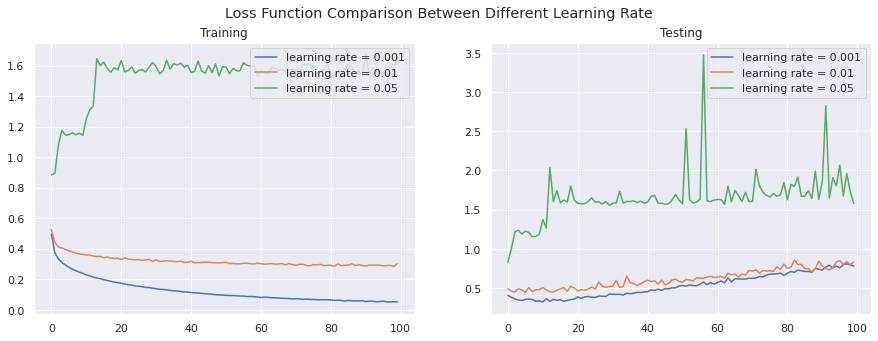

In [ ]:
# visualization
sns.set(font_scale=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
fig.suptitle('Loss Function Comparison Between Different Learning Rate')


# loss fucntion with respect to different learning rate
for idx in range(total_lr):
  label = 'learning rate = {lr}'.format(lr = lr_list[idx])
  ax1.plot(recording_loss_train1[idx], label = label)
  ax2.plot(recording_loss_test1[idx], label = label)

ax1.set_title('Training')
ax2.set_title('Testing')
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.show()

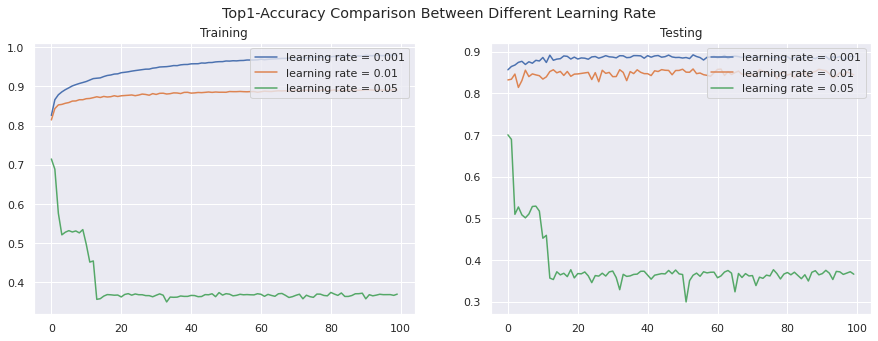

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
fig.suptitle('Top1-Accuracy Comparison Between Different Learning Rate')


# Top1-Accuracy with respect to different learning rate
for idx in range(total_lr):
  label = 'learning rate = {lr}'.format(lr = lr_list[idx])
  ax1.plot(recording_top1_acc_train1[idx], label = label)
  ax2.plot(recording_top1_acc_test1[idx], label = label)

ax1.set_title('Training')
ax2.set_title('Testing')
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.show()

### Findings and insights:
- Most trivially, we can see that, with **large learning rate**, after batch 0 the loss tends to be bigger.
  - reason can be: **Gradient Descent Method** has good property within small neighbourhood of current point. Therefore, if the learning rate is too big, then we cannot guarantee this update of weights can help to decrease the loss function value;
- When learning rate = 0.05, the model disverges.
  - It seems that, this model stucks in a **very bad** local minimum.
- SGD cannot guarantee the update of weights will lead to smaller loss function value. If we **fix the learning rate**, then this model even **cannot guarantee the convergence theoretically**.
  - One reason is, the gradient calculated by batch samples is only **an estimator** for the ground-truth gradient. Moreover, this estimator has very large varaiance if the batch size is small.
  - Thus, we cannot guarantee the update of weights is good if our learning rate is rather big. However, the **large variance** will help this model get out of local minimum. 
- If the learning rate is **relatively big**, then the model will be easy to be stuck in large-loss-function area. This is extremely bad for the model training process. 
  - e.g., learning rate = 0.05.
- The smaller the learning rate is, the smoother the loss curve will be.
  - When lr = 0.01, the orange loss curve seems fluctuate often;
  - When lr = 0.001, the blue loss curve is much smoother.

## 5. Exploration on the Batch Size Hyper-parameter
- we will apply batch size = [8, 256, 1024] to check the convergence (loss curve) under the same algorithm;
- we focus on (similar schema with learning rate exploration):
  - 'loss' curve on training and testing set;
  - 'top1-accuracy' curve on training and testing set;

### Experiment:

In [ ]:
batch_size_list = [8, 256, 1024]
recording_loss_train2 = {}
recording_loss_test2 = {}
recording_top1_acc_train2 = {}
recording_top1_acc_test2 = {}

In [ ]:
# train 3 NN models and record their corresponding history trajactory
for idx in range(3):
  bs = batch_size_list[idx]
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Flatten(input_shape = (28, 28)))
  model.add(tf.keras.layers.Dense(128, activation = 'relu'))
  model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
  )
  print('------------------------------------------------')
  print('training trajactory of model {index}'.format(index = idx + 1))
  
  history = model.fit(x_train_normal, y_train, validation_data = (x_test_normal, y_test), batch_size = bs, epochs=100, verbose=0)

  recording_loss_train2[idx], recording_loss_test2[idx] = history.history['loss'], history.history['val_loss']
  recording_top1_acc_train2[idx], recording_top1_acc_test2[idx] = history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy']

------------------------------------------------
training trajactory of model 1
------------------------------------------------
training trajactory of model 2
------------------------------------------------
training trajactory of model 3


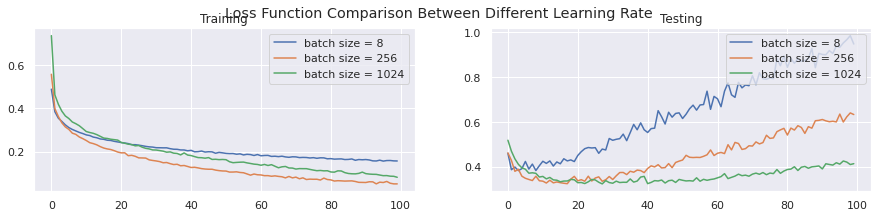

In [ ]:
# visualization
sns.set(font_scale=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 3)
fig.suptitle('Loss Function Comparison Between Different Learning Rate')


# loss fucntion with respect to different learning rate
for idx in range(3):
  label = 'batch size = {batch_size}'.format(batch_size = batch_size_list[idx])
  ax1.plot(recording_loss_train2[idx], label = label)
  ax2.plot(recording_loss_test2[idx], label = label)

ax1.set_title('Training')
ax2.set_title('Testing')
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.show()

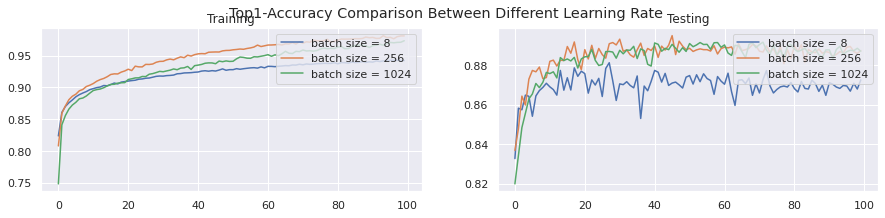

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 3)
fig.suptitle('Top1-Accuracy Comparison Between Different Learning Rate')


# Top1-Accuracy with respect to different learning rate
for idx in range(3):
  label = 'batch size = {batch_size}'.format(batch_size = batch_size_list[idx])
  ax1.plot(recording_top1_acc_train2[idx], label = label)
  ax2.plot(recording_top1_acc_test2[idx], label = label)

ax1.set_title('Training')
ax2.set_title('Testing')
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.show()

### Findings and insights:
- If we apply small batch size, then the update for parameters will be very noisy.
  - It can be observed from the **accuracy curve** and **loss curve** when batch size = 8 that, the curve is very distorted, which means the approximate gradient (from SGD) might be quite different from the expectation.
- Moreover, when fixing the epoches number, **small batch size** will lead to much longer training time!
- However, if we choose a very big batch size, namely batch size = 1024, then it can be observed that, **loss function for training will converge to a large value**.
  - It means that, with large batch size (batch size = 1024), our model will be prone to stuck in local minimum.
- Therefore, it is recommended that, we should choose an appropriate batch size, not too big or too small to achieve the trade-off between **randomness** and **stability** of gradient estimator.
  - Perhaps batch size = 32 or 256 can be a good choice.

## 6. Extra exploration including:
- MLP with well-sturctured architecture.
  - We apply 3 Residual Blocks, in each Residual Block, there are 2 hidden layers.
    - after each hidden layer, we do Batch Normalization;
    - in last step, we do Residual Connection;
  - In output layer, we do Dropout;
- CNN toy example.

### a) MLP model (with more detailed architecture)

#### Model Building

In [ ]:
# use another approach to define model architecture
# previously, I make use of "Sequential API"
# this time, I try to use "Functional API" to define MLP model

# define the residual block function
def residual_block(input_x):
  # input_x is 64-dim

  # first hidden layer (128 hidden units)
  x = tf.keras.layers.Dense(128, activation = 'linear')(input_x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  # second hidden layer (64 hidden units)
  x = tf.keras.layers.Dense(64, activation = 'linear')(input_x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)

  # residual connection
  y = tf.keras.layers.Add()([x, input_x])

  return y



input_layer = tf.keras.Input(shape = (28, 28))
x = tf.keras.layers.Flatten()(input_layer)

# 1-st layer (follow the CNN fashion, first do convolution (linear Dense layer), then BN, lastly through activation layer)
x = tf.keras.layers.Dense(64, activation='linear')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

# Residual Block 1
x = residual_block(x)

# Residual Block 2
x = residual_block(x)

# Residual Block 3
x = residual_block(x)

x = tf.keras.layers.Dense(10, activation = 'linear')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output_layer = tf.keras.layers.Softmax(axis = -1)(x)

mlp = tf.keras.Model(inputs = input_layer, outputs = output_layer, name = 'fashion_mnist_mlp')

mlp.summary()

Model: "fashion_mnist_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_24 (Flatten)           (None, 784)          0           ['input_2[0][0]']                
                                                                                                  
 dense_54 (Dense)               (None, 64)           50240       ['flatten_24[0][0]']             
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 64)          256         ['dense_54[0][0]']               
 rmalization)                                                                     

#### Architecture Visualization

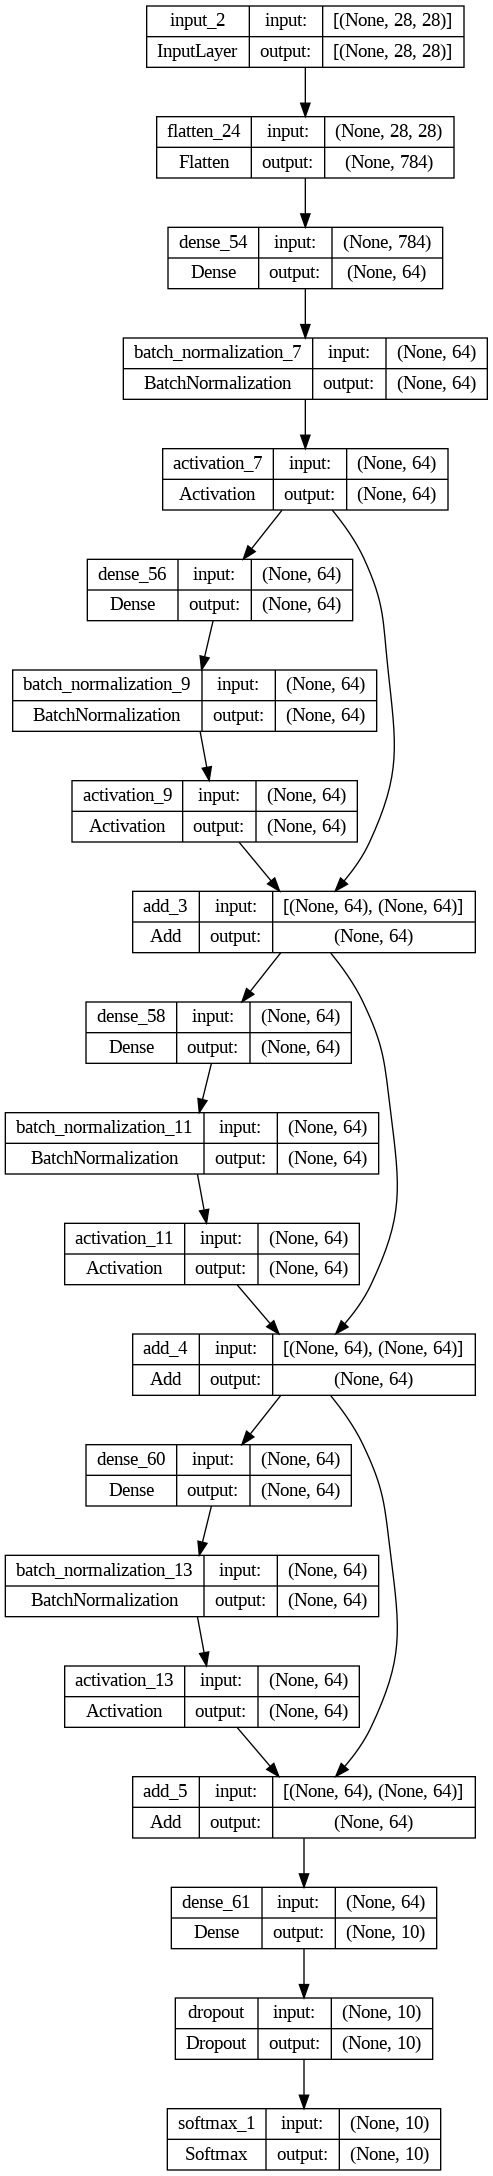

In [ ]:
tf. keras.utils.plot_model(mlp, "mlp_res_BN.png", show_shapes=True)

#### Model Training and Performance Evaluation

In [ ]:
# training setting
mlp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2)],
)

# training process

history = mlp.fit(x_train_normal, y_train, validation_data = (x_test_normal, y_test), batch_size=32, epochs=100, verbose=0)

# model evaluation
_, train_acc, _ = mlp.evaluate(x_train_normal, y_train)
_, test_acc, _ = mlp.evaluate(x_test_normal, y_test)

print('Accuracy Report:')
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

313/313 [==============================] - 1s 3ms/step - loss: 0.4237 - sparse_categorical_accuracy: 0.8880 - sparse_top_k_categorical_accuracy: 0.9657
Accuracy Report:
Train: 0.975, Test: 0.888


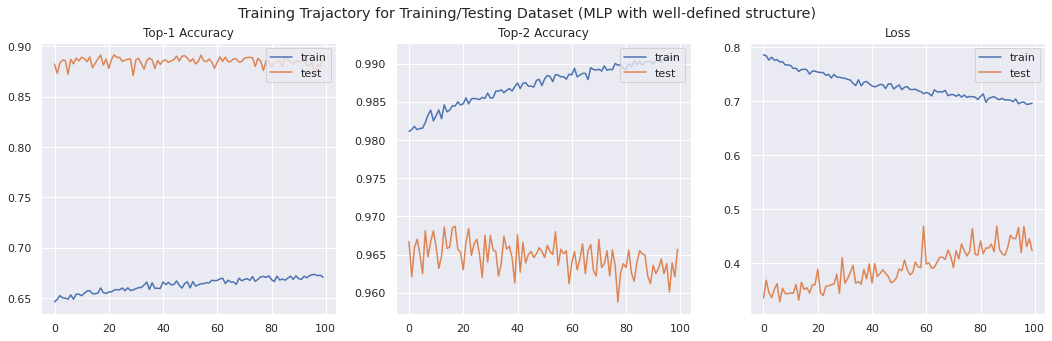

In [ ]:
# visualization for [top1 accuracy, top2 accurcay, loss] comparison
sns.set(font_scale=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(18, 5)
fig.suptitle('Training Trajactory for Training/Testing Dataset (MLP with well-defined structure)')

# top-1 accuracy
ax1.set_title('Top-1 Accuracy')
ax1.plot(history.history['sparse_categorical_accuracy'], label='train')
ax1.plot(history.history['val_sparse_categorical_accuracy'], label='test')
ax1.legend(loc = 'upper right')

# top-2 accuracy
ax2.set_title('Top-2 Accuracy')
ax2.plot(history.history['sparse_top_k_categorical_accuracy'], label='train')
ax2.plot(history.history['val_sparse_top_k_categorical_accuracy'], label='test')
ax2.legend(loc = 'upper right')

# loss
ax3.set_title('Loss')
ax3.plot(history.history['loss'], label='train')
ax3.plot(history.history['val_loss'], label='test')
ax3.legend(loc = 'upper right')

plt.show()

#### Findings:
- Compare with **shallow NN (28*28-128-10)**, this well-structured NN performs better with respect to generalization ability
  - test accuracy for shallow NN is around 0.88
  - test accuracy for well-structured NN is around 0.89
  - improvement is not significant indeed
- Considering the test loss, it can be observed that, the increase of loss function is smaller, which probably means this model has stronger generalization ability.

### b) CNN toy example

 #### Model Building

In [ ]:
# define the Convlution Unit
def Conv_BN_Relu(filters, kernel_size, strides, input_layer):
  x = tf.keras.layers.Conv2D(filters, kernel_size, strides = strides, padding = 'same')(input_layer)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  return x


input_layer = tf.keras.Input(shape = (28, 28, 1))
# conv layer 1
conv1 = Conv_BN_Relu(16, (3,3), 1, input_layer)
conv1_maxp = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'valid')(conv1)

# conv layer 2
conv2 = Conv_BN_Relu(32, (3,3), 1, conv1_maxp)
conv2_maxp = tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'valid')(conv2)

# conv layer 3
conv3 = Conv_BN_Relu(64, (3,3), 1, conv2_maxp)
conv3_maxp = tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2, padding = 'valid')(conv3)


# global average pooling
gap = tf.keras.layers.GlobalAveragePooling2D()(conv3_maxp)
x = tf.keras.layers.Flatten()(gap)
x = tf.keras.layers.Dense(1024)(x)
output_layer = tf.keras.layers.Softmax(axis = -1)(x)


cnn = tf.keras.Model(inputs = input_layer, outputs = output_layer, name = 'fashion_mnist_cnn')

cnn.summary()

Model: "fashion_mnist_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 batch_normalization_14 (Bat  (None, 28, 28, 16)       64        
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)  

#### Model Training and Performance Evaluation

In [ ]:
# training setting
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2)],
)

# training process

history = cnn.fit(x_train_normal, y_train, validation_data = (x_test_normal, y_test), batch_size = 32, epochs=50, verbose=1)

# model evaluation
_, train_acc, _ = cnn.evaluate(x_train_normal, y_train)
_, test_acc, _ = cnn.evaluate(x_test_normal, y_test)

print('Accuracy Report:')
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Epoch 1/50
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2862 - sparse_categorical_accuracy: 0.8963 - sparse_top_k_categorical_accuracy: 0.9730 - val_loss: 0.3468 - val_sparse_categorical_accuracy: 0.8731 - val_sparse_top_k_categorical_accuracy: 0.9638
Epoch 2/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2585 - sparse_categorical_accuracy: 0.9059 - sparse_top_k_categorical_accuracy: 0.9764 - val_loss: 0.3148 - val_sparse_categorical_accuracy: 0.8906 - val_sparse_top_k_categorical_accuracy: 0.9714
Epoch 3/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2389 - sparse_categorical_accuracy: 0.9135 - sparse_top_k_categorical_accuracy: 0.9802 - val_loss: 0.2821 - val_sparse_categorical_accuracy: 0.9028 - val_sparse_top_k_categorical_accuracy: 0.9724
Epoch 4/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2220 - sparse_categorical_accuracy: 0.9188 - sparse_top_k_categorical_accuracy: 0.9820 - val_loss: 0

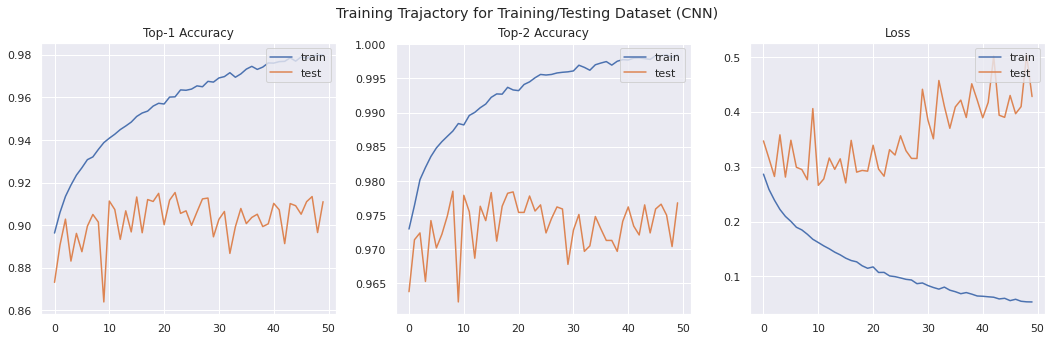

In [ ]:
# visualization for [top1 accuracy, top2 accurcay, loss] comparison
sns.set(font_scale=1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

fig.set_size_inches(18, 5)
fig.suptitle('Training Trajactory for Training/Testing Dataset (CNN)')

# top-1 accuracy
ax1.set_title('Top-1 Accuracy')
ax1.plot(history.history['sparse_categorical_accuracy'], label='train')
ax1.plot(history.history['val_sparse_categorical_accuracy'], label='test')
ax1.legend(loc = 'upper right')

# top-2 accuracy
ax2.set_title('Top-2 Accuracy')
ax2.plot(history.history['sparse_top_k_categorical_accuracy'], label='train')
ax2.plot(history.history['val_sparse_top_k_categorical_accuracy'], label='test')
ax2.legend(loc = 'upper right')

# loss
ax3.set_title('Loss')
ax3.plot(history.history['loss'], label='train')
ax3.plot(history.history['val_loss'], label='test')
ax3.legend(loc = 'upper right')

plt.show()

#### Findings:
- This CNN constitutes 90k params, which can achieve around 0.91, 0.92 test accuracy
  - This improvement is significant compared with well-structured MLP, whose test accuracy is around 0.89. Moreover, their number of parameters are also simliar.
  - This shows CNN architecture can successfully capture the spatial information of images comapred with MLP architecutre.